In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mlflow

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
import warnings
warnings.filterwarnings('ignore')

cpu


In [3]:
matplotlib.rcParams['figure.figsize'] = [14.0, 6.0]
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['lines.linewidth'] = 2.0

# Read S&P500 index data

In [4]:
data = pd.read_csv('S&P-20y.csv',  parse_dates=['Date'], index_col=['Date'])

In [5]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-10-25,1398.130005,1398.130005,1362.209961,1364.900024,1364.900024,1315600000
2000-10-26,1364.900024,1372.719971,1337.810059,1364.439941,1364.439941,1303800000
2000-10-27,1364.439941,1384.569946,1364.130005,1379.579956,1379.579956,1086300000
2000-10-30,1379.579956,1406.359985,1376.859985,1398.660034,1398.660034,1186500000
2000-10-31,1398.660034,1432.219971,1398.660034,1429.400024,1429.400024,1366400000
...,...,...,...,...,...,...
2020-10-19,3493.659912,3502.419922,3419.929932,3426.919922,3426.919922,4086200000
2020-10-20,3439.379883,3476.929932,3435.649902,3443.120117,3443.120117,3901260000
2020-10-21,3439.909912,3464.860107,3433.060059,3435.560059,3435.560059,4097750000


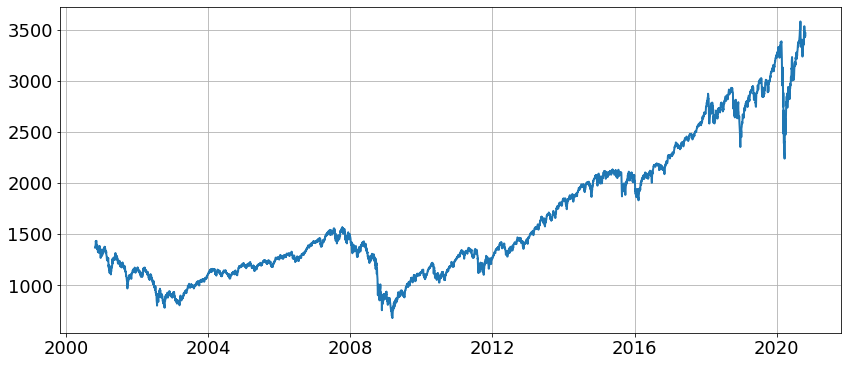

In [6]:
plt.plot(data.index, data['Close'])
plt.grid(True)
plt.show()

# Add return column

In [7]:
data['Ret'] = data['Close'].pct_change()

data.dropna(inplace=True)

r = data['Ret'].values
data

,Open,High,Low,Close,Adj Close,Volume,Ret
Date,,,,,,,
2000-10-26,1364.900024,1372.719971,1337.810059,1364.439941,1364.439941,1303800000,-0.000337
2000-10-27,1364.439941,1384.569946,1364.130005,1379.579956,1379.579956,1086300000,0.011096
2000-10-30,1379.579956,1406.359985,1376.859985,1398.660034,1398.660034,1186500000,0.013830
2000-10-31,1398.660034,1432.219971,1398.660034,1429.400024,1429.400024,1366400000,0.021978
2000-11-01,1429.400024,1429.599976,1410.449951,1421.219971,1421.219971,1206800000,-0.005723
...,...,...,...,...,...,...,...
2020-10-19,3493.659912,3502.419922,3419.929932,3426.919922,3426.919922,4086200000,-0.016330
2020-10-20,3439.379883,3476.929932,3435.649902,3443.120117,3443.120117,3901260000,0.004727
2020-10-21,3439.909912,3464.860107,3433.060059,3435.560059,3435.560059,4097750000,-0.002196


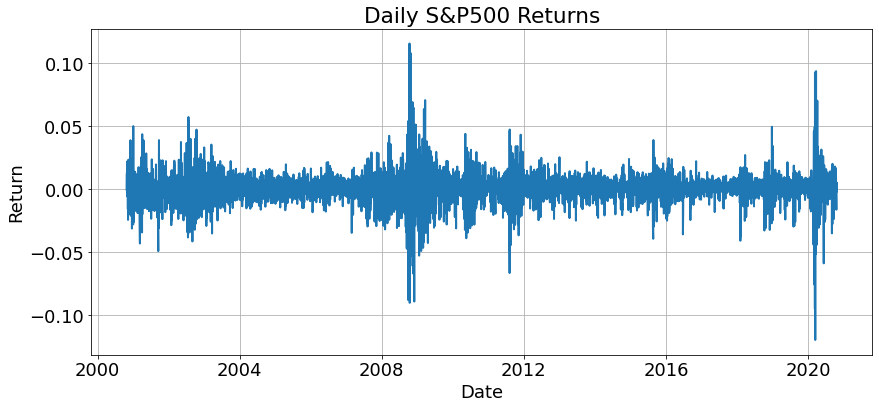

In [8]:
plt.plot(data.index, data['Ret'])
plt.grid(True)
plt.title('Daily S&P500 Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

# Make batches

    

In [9]:
import random


def make_batch(series, batch_size=10, input_len=5, output_len=1):
    
    X = np.empty( (batch_size, input_len), dtype=np.float32)
    y = np.empty( (batch_size, output_len), dtype=np.float32)
    ndx = []
    
    for i in range(batch_size):
        k = random.randint(0, len(series) - input_len - output_len)
        X[i,:] = series[k:k+input_len]
        y[i,0] = series[k+input_len]
        ndx.append(k)
        
    X_tensor = torch.from_numpy(X).float().to(device)
    y_tensor = torch.from_numpy(y).float().to(device)    
    
    return X_tensor, y_tensor, ndx

In [10]:
X_tensor, y_tensor, ndx = make_batch(r, 10, 5)

with np.printoptions(precision=4, suppress=True):
    print('\nX:\n', X_tensor)
    print('\ny:\n', y_tensor)
    print('\nndx:\n', ndx)


X:
 tensor([[ 1.5197e-03,  1.6777e-02, -2.3679e-03, -4.3125e-03, -1.0475e-02],
        [ 7.2236e-03,  2.1148e-03,  1.0396e-02,  4.2698e-03,  1.7728e-03],
        [-2.8032e-03,  4.9025e-03,  6.6553e-03, -2.8552e-03,  6.9762e-03],
        [ 6.4998e-03, -5.7368e-03, -8.5878e-03,  6.4442e-03,  5.2966e-03],
        [-8.0947e-03,  8.6629e-03, -1.4775e-03,  2.5400e-03, -3.2597e-03],
        [ 5.2479e-03,  1.5964e-02,  1.5433e-03, -9.4995e-03,  4.5433e-03],
        [-4.6443e-03,  3.5895e-03,  6.7343e-03,  1.1569e-02,  1.7456e-05],
        [-6.5450e-03,  3.6461e-03,  8.8191e-04, -5.9626e-03, -7.1015e-04],
        [-2.3203e-03,  5.0161e-03,  1.7544e-03,  4.8816e-04, -4.8492e-03],
        [-7.0488e-03,  4.6443e-03, -4.1311e-03,  1.4709e-03,  4.8436e-03]])

y:
 tensor([[ 0.0165],
        [ 0.0015],
        [-0.0015],
        [-0.0093],
        [ 0.0100],
        [-0.0098],
        [ 0.0021],
        [ 0.0075],
        [ 0.0003],
        [-0.0019]])

ndx:
 [1252, 1347, 4827, 4000, 1325, 903, 4630,

# Define a NN

In [11]:
class GMM_Net(nn.Module):
    
    def __init__(
            self,
            num_inputs=5,
            num_mixtures=5,
            num_hidden=[32,32],
            activation=F.selu,
            *args,
            **kwargs
    ):
        super(GMM_Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_mixtures = num_mixtures
        self.num_hidden = num_hidden
        self.activation = activation
        self.dropout = nn.Dropout(p=0.2)

        prev_num_units = 2*num_inputs # number of inputs: [r, r^2, cumsum r]
        self.layer_list = []
        
        # layers
        for num_units in self.num_hidden:
            self.layer_list.append(nn.Linear(prev_num_units, num_units))
            prev_num_units = num_units
        
        # Final ayer with GMM parameters
        self.layer_list.append(nn.Linear(prev_num_units, 3*num_mixtures))
        
        self.layers = nn.ModuleList(self.layer_list)
    
    
    def name(self):
        return f'{self.num_inputs}->{self.num_hidden}->{self.num_mixtures}:{self.activation.__name__}'
    
    
    def forward(self, x_):
        
        # Add x^2 as an extra column
        x = torch.cat( (x_, x_**2), dim=1)
        
        # Forward pass all layers
        for layer in self.layer_list[:-1]:
            x = self.activation(self.dropout(layer(x)))
            #x = self.activation(layer(x))
        
        # now activation in the last layer, normalize between 0,1
        x = torch.sigmoid(self.layer_list[-1](x))
        
        # split the ouput into w,mu,sigma and apply appropriate transforms
        k = self.num_mixtures
        
        # fraction between largest and smallest weight is exp(6)
        w = F.softmax(3*x[:,:k], dim=1)
        
        # mu somewhere between -0.05 nd 0.05
        mu = 0.1*x[:,k:2*k] - 0.05
        
        # sigma in the range exp(-8).. exp(-2)
        sigma = torch.exp(-4*x[:,2*k:]-2)
        
        return w, mu, sigma
    
    
    def prob(self, w, mu, sigma, y):
        norm = Normal(loc=0, scale=1)

        num_mixtures = w.shape[-1]

        y_ = y.repeat(1, num_mixtures)
        z_ = (y_ - mu) / sigma
        p_ = torch.exp(norm.log_prob(z_)) / sigma

        p = torch.sum(w * p_, -1, keepdims=True)
        return p
    

In [12]:
settings = {
    'num_inputs': 20,
    'num_hidden': [128, 128],
    'num_mixtures': 5,
    'activation': F.selu,
    'learning_rate': 1E-5,
    'batch_size': 64
}

net = GMM_Net(**settings)

print(net.layers)
print('\nNetwork name:', net.name())

optimizer = optim.Adam(net.parameters(), lr=settings['learning_rate'])

ModuleList(
  (0): Linear(in_features=40, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=15, bias=True)
)

Network name: 20->[128, 128]->5:selu


# Train the Neural Network

In [13]:
# Split the data in a train and tetst set
split = int(len(r)*0.75)

r_train = r[:split]
r_test = r[split:]

In [14]:
report_steps = 1000

## Initialize MLFlow experiment

In [15]:
EXPERIMENT_NAME = 'GMM_net'

exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if exp is None:
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
    exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

EXPERIMENT_ID = exp.experiment_id
print(f'experiment {EXPERIMENT_ID}: {EXPERIMENT_NAME}')

experiment 1: GMM_net


# Start training and logging

In [16]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=net.name()):

    mlflow.log_params(settings)

    for step in range(30):

        # -----------------------------------------------
        # Train
        # -----------------------------------------------
        train_loss = 0.0
        net.train() # make sure we are in train mode
        for i in range(report_steps):

            # Make a batch
            X_tensor, y_tensor, ndx = make_batch(r_train, settings['batch_size'], settings['num_inputs'], 1)

            # Compute the predicted day-ahead density
            w, mu, sigma = net.forward(X_tensor)

            # evaluate the actual day ahead move
            p = net.prob(w, mu, sigma, y_tensor)

            # use the prob as a loss via neg log likelihood.
            losses = -torch.log(p)
            loss = torch.mean(losses)

            train_loss += loss.item()

            # Compute the gradients and backpropagate the error
            loss.backward()  
            
            # Apply gradient clipping
            torch.nn.utils.clip_grad_value_(net.parameters(), 0.1)

            # Update the weights
            optimizer.step()

        train_loss /= report_steps

        # -----------------------------------------------
        # Test
        # -----------------------------------------------
        test_loss = 0.0
        net.eval() # make sure we are in eval mode
        for i in range(report_steps):
            # Make a batch
            X_tensor, y_tensor, ndx = make_batch(r_test, settings['batch_size'], settings['num_inputs'], 1)

            # Compute the predicted day-ahead density
            w, mu, sigma = net.forward(X_tensor)

            # evaluate the actual day ahead move
            p = net.prob(w, mu, sigma, y_tensor)

            losses = -torch.log(p)
            loss = torch.mean(losses)

            test_loss += loss.item()

        test_loss /= report_steps

        # -----------------------------------------------
        # Report
        # -----------------------------------------------
        print(f'step {step}, train loss = {train_loss:.4g},  test loss = {test_loss:.4g}')
        mlflow.log_metric('train_loss', train_loss, step=step)
        mlflow.log_metric('test_loss', test_loss, step=step)


step 0, train loss = -2.999,  test loss = -3.239
step 1, train loss = -3.079,  test loss = -3.258
step 2, train loss = -3.088,  test loss = -3.264
step 3, train loss = -3.088,  test loss = -3.269
step 4, train loss = -3.107,  test loss = -3.285
step 5, train loss = -3.122,  test loss = -3.314
step 6, train loss = -3.129,  test loss = -3.333
step 7, train loss = -3.141,  test loss = -3.34
step 8, train loss = -3.146,  test loss = -3.362
step 9, train loss = -3.157,  test loss = -3.365
step 10, train loss = -3.164,  test loss = -3.386
step 11, train loss = -3.165,  test loss = -3.386
step 12, train loss = -3.175,  test loss = -3.39
step 13, train loss = -3.185,  test loss = -3.385
step 14, train loss = -3.188,  test loss = -3.402
step 15, train loss = -3.189,  test loss = -3.398
step 16, train loss = -3.19,  test loss = -3.39
step 17, train loss = -3.199,  test loss = -3.406
step 18, train loss = -3.204,  test loss = -3.393
step 19, train loss = -3.212,  test loss = -3.397
step 20, train

In [17]:
def gmm_sample(w, mu, sigma):
    i = np.random.choice(w.shape[1], p=w.detach().numpy()[0,:])
    mu_i = mu.detach().numpy()[0,i]
    sigma_i = sigma.detach().numpy()[0,i]
    return np.random.normal(loc=mu_i, scale=sigma_i, size=None) 

In [18]:
data.index[-160]

Timestamp('2020-03-10 00:00:00')

In [19]:
num_paths = 500
num_steps = 20
num_inputs = settings['num_inputs']

sim = np.empty( (num_paths, num_steps+num_inputs), dtype=np.float32)

offset = 110
sim[0,:num_inputs] = r_test[-num_inputs-offset:-offset]

for i in range(num_paths):
    sim[i,:num_inputs] = sim[0,:num_inputs]
    for j in range(num_steps):
        
        X = sim[i,j:num_inputs+j] .reshape(1,num_inputs)
        
        X_tensor = torch.from_numpy(X).float().to(device)    
        
        w, mu, sigma = net.forward(X_tensor)
        y_sample = gmm_sample(w,mu,sigma)
        sim[i, num_inputs+j] = y_sample
        

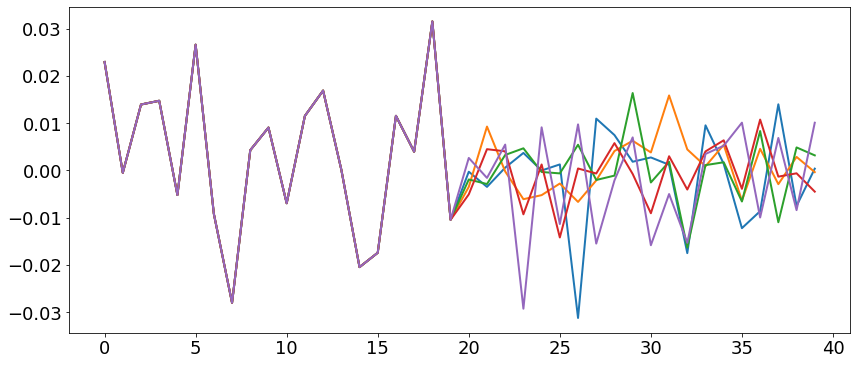

In [20]:
plt.plot(np.transpose(sim)[:100,:5])
plt.show()

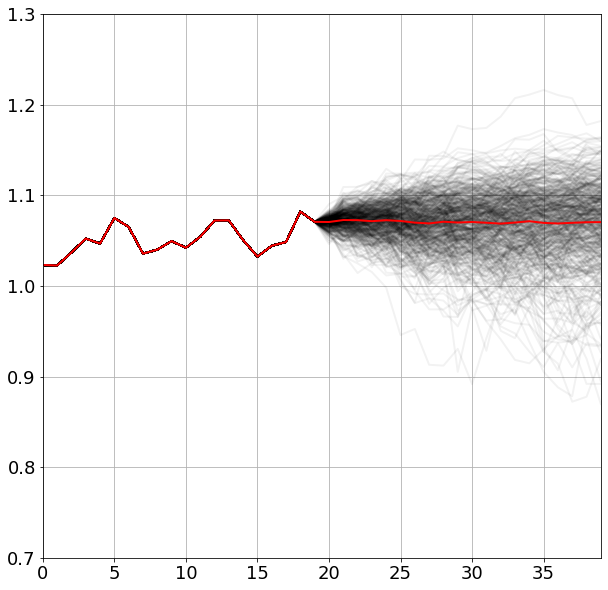

In [21]:
plt.figure(figsize=(10,10)) 

S = np.exp(np.cumsum(np.transpose(sim),axis=0))
plt.plot(np.exp(np.cumsum(np.transpose(sim),axis=0)),c='k',alpha=.05)
plt.plot(np.mean(S,axis=1),c='r')
plt.ylim(0.7,1.3)
plt.xlim(0,39)
plt.grid()
plt.show()

In [22]:
num_paths = 10
num_steps = len(r) - num_inputs
num_inputs = settings['num_inputs']

sim = np.empty( (num_paths, num_steps+num_inputs), dtype=np.float32)

offset = 10
sim[0,:num_inputs] = r_train[-num_inputs-offset:-offset]

for i in range(num_paths):
    sim[i,:num_inputs] = sim[0,:num_inputs]
    for j in range(num_steps):
        
        X = sim[i,j:num_inputs+j] .reshape(1,num_inputs)
        
        X_tensor = torch.from_numpy(X).float().to(device)    
        
        w, mu, sigma = net.forward(X_tensor)
        y_sample = gmm_sample(w,mu,sigma)
        sim[i, num_inputs+j] = y_sample
        

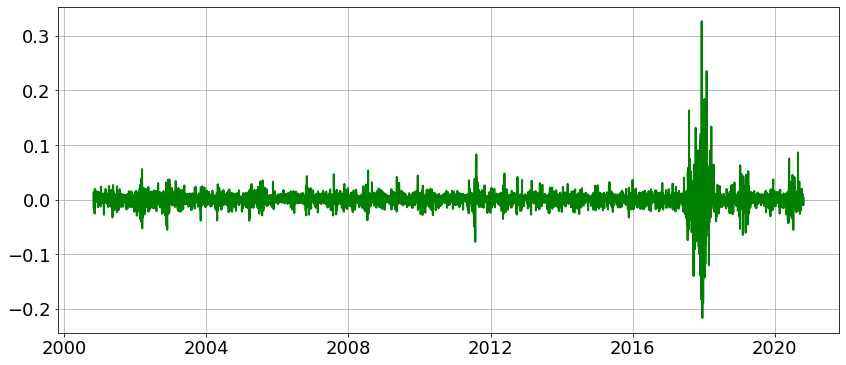

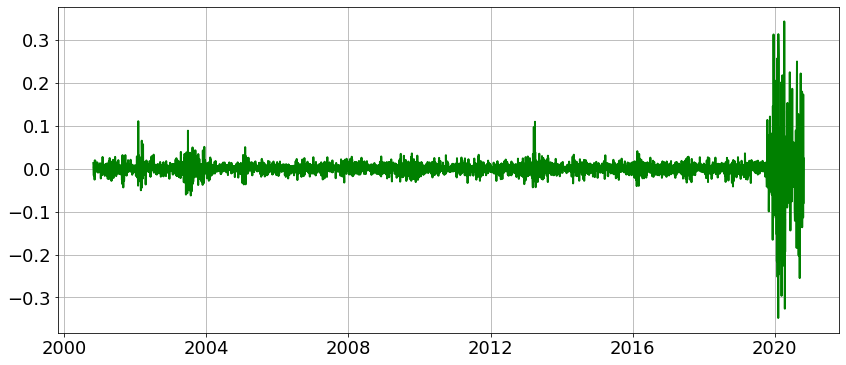

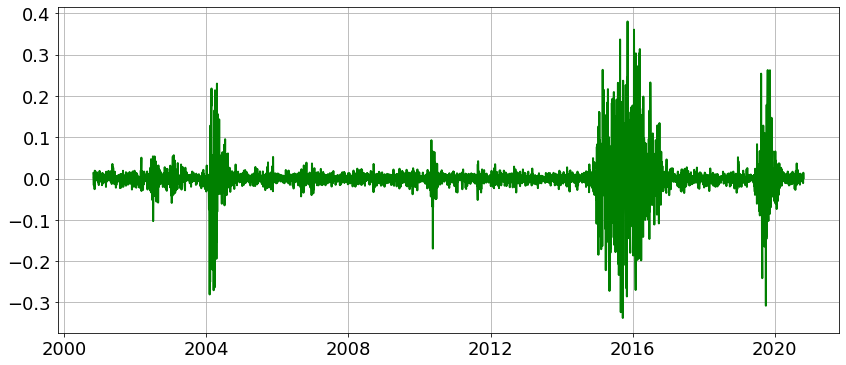

In [23]:
plt.plot(data.index, np.transpose(sim)[:,0], c='g')
plt.grid()
plt.show()

plt.plot(data.index, np.transpose(sim)[:,1], c='g')
plt.grid()
plt.show()

plt.plot(data.index, np.transpose(sim)[:,2], c='g')
plt.grid()
plt.show()